In [ ]:
# Install kaggle API
!pip install -q kaggle

In [ ]:
# Upload kaggle.json ke Google Colaboratory
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
    print('File yang diupload "{nama}" dengan ukuran {panjang} bytes'.format(nama=fn, panjang=len(uploaded[fn])))

In [ ]:
# Membuat folder .kaggle di dalam folder root, kemudian menyalin berkas kaggle.json pada direktori aktif saat ini ke folder .kaggle
!chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/

In [ ]:
# Mengunduh dataset menggunakan Kaggle CLI
!kaggle datasets download -d alpha46663/distracted-driver-dataset

In [ ]:
# Mengekstrak berkas zip ke direktori aktif saat ini
!unzip -q distracted-driver-dataset.zip

In [ ]:
# Install depedency
!pip install -q skorch
!pip install -q scikit-learn>=0.24.0

In [28]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from skorch.dataset import CVSplit
from skorch.callbacks import EpochScoring
from skorch.classifier import NeuralNetClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torch.optim import Adam, SGD
from torch.nn import ReLU, Sigmoid, Tanh, Softmax, CrossEntropyLoss
from torch.nn import Module, Sequential, Conv2d, MaxPool2d, Flatten, Linear

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-darkgrid')

torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using {} device'.format(device))

Using cuda:0 device


In [2]:
def data_preparation(base_path, csv_filename, test_ratio=0.2):
    df = pd.read_csv(csv_filename, usecols=['classname', 'img'])
    df = df[df['classname'].isin(['c0','c1','c2','c3','c4'])].reset_index(drop=True)
    
    train_set, test_set = train_test_split(df, test_size=test_ratio, stratify=df[['classname']], random_state=123)
    
    print("{:<18}: {} sample".format("Total samples", len(df)))
    print("{:<18}: {} sample".format("Train samples", len(train_set)))
    print("{:<18}: {} sample".format("Test samples", len(test_set)))
    
    return train_set, test_set


def data_preprocessing(base_path, df, size:list, prefix='train'):
    images = []
    for path in df.values:
        image = cv2.imread(f"{base_path + path[0]}/{path[1]}").astype('float32')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, tuple(size))
        images.append(image)
    
    
    X = np.array(images) / 255.0
    X = X.reshape(X.shape[0], 3, size[0], size[1]).astype(np.float32)
    y = np.asarray(df['classname'].str.extract('(\d+)', expand=False), dtype=np.int64)
    
    print(f"{prefix} images resized to {size}")
    
    return X, y

In [25]:
class ConvNeuralNet(Module):
    def __init__(self, hidden, act='relu'):
        super().__init__()
        self.conv1 = Conv2d(in_channels=3,
                            out_channels=4,
                            kernel_size=(3, 3),
                            bias=False)
        
        self.conv2 = Conv2d(in_channels=4,
                        out_channels=3,
                        kernel_size=(3, 3),
                        bias=False)
        
        self.pool = MaxPool2d(2, 2)
        
        self.fc1 = Linear(in_features=3 * 30 * 30,
                          out_features=hidden,
                          bias=False)
        
        self.fc2 = Linear(in_features=hidden,
                          out_features=5,
                          bias=False)
        
        self.softmax = Softmax(dim=1)
        
        
        if act=='sigmoid':
            self.act = Sigmoid()
        elif act=='tanh':
            self.act = Tanh()
        else:
            self.act = ReLU()
    

    def forward(self, x_input):
        x = self.act(self.conv1(x_input))
        x = self.act(self.conv2(x))
        x = self.pool(x)
        x = self.act(self.fc1(torch.flatten(x, start_dim=1)))
        x = self.softmax(self.fc2(x))

        return x

In [4]:
imgs_path = f'imgs/'
csv_file = 'driver_imgs_list.csv'
img_size = [64, 64]
test_ratio = 0.1
k = 5

In [26]:
train_df, test_df = data_preparation(imgs_path, csv_file, test_ratio)

Total samples     : 11745 sample
Train samples     : 10570 sample
Test samples      : 1175 sample


In [6]:
x_train, y_train = data_preprocessing(imgs_path, train_df, img_size, prefix='train')
x_test, y_test = data_preprocessing(imgs_path, test_df, img_size, prefix='test')

train images resized to [64, 64]
test images resized to [64, 64]


In [7]:
model = NeuralNetClassifier(ConvNeuralNet,
                            criterion=CrossEntropyLoss,
                            iterator_train__shuffle=True,
                            train_split=CVSplit(cv=k, stratified=True, random_state=123),
                            callbacks=[EpochScoring(scoring='accuracy', on_train=True, lower_is_better=False)],
                            verbose=0,
                            device=device)

In [27]:
param_grid = {'lr': [0.0001, 0.001, 0.01, 0.1, 0.5],
              'module__hidden': [4, 8, 16, 32, 64],
              'module__act': ['relu', 'sigmoid', 'tanh'],
              'batch_size': [8, 16, 32, 64, 128],
              'max_epochs': [10, 15, 20, 25, 50],
              'optimizer': [Adam, SGD]}

In [9]:
params = HalvingGridSearchCV(model,
                             param_grid,
                             scoring='accuracy',
                             aggressive_elimination=True,
                             return_train_score=True,
                             min_resources=165,
                             factor=4,
                             random_state=123,
                             verbose=1
                            ).fit(x_train, y_train)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 4
min_resources_: 165
max_resources_: 10570
aggressive_elimination: True
factor: 4
----------
iter: 0
n_candidates: 3750
n_resources: 165
Fitting 5 folds for each of 3750 candidates, totalling 18750 fits
----------
iter: 1
n_candidates: 938
n_resources: 165
Fitting 5 folds for each of 938 candidates, totalling 4690 fits
----------
iter: 2
n_candidates: 235
n_resources: 165
Fitting 5 folds for each of 235 candidates, totalling 1175 fits
----------
iter: 3
n_candidates: 59
n_resources: 660
Fitting 5 folds for each of 59 candidates, totalling 295 fits
----------
iter: 4
n_candidates: 15
n_resources: 2640
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 5
n_candidates: 4
n_resources: 10560
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [10]:
df_hgs = pd.DataFrame(params.cv_results_)
df_hgs.to_csv('hasil HalvingGridSearchCV.csv', sep=',', encoding='utf-8', index=False)
df_hgs.head(10)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_lr,param_max_epochs,param_module__act,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,165,4.099666,7.588509,0.007458,0.007197,8,0.0001,10,relu,...,0.193939,0.082656,2307,0.212121,0.250000,0.257576,0.250000,0.234848,0.240909,0.016177
1,0,165,0.283410,0.005537,0.003455,0.000042,8,0.0001,10,relu,...,0.139394,0.036364,4671,0.174242,0.234848,0.265152,0.166667,0.136364,0.195455,0.047286
2,0,165,0.305409,0.006156,0.003604,0.000137,8,0.0001,10,relu,...,0.187879,0.075210,2672,0.219697,0.333333,0.287879,0.318182,0.272727,0.286364,0.039626
3,0,165,0.302091,0.013096,0.003528,0.000064,8,0.0001,10,relu,...,0.193939,0.073231,2482,0.151515,0.143939,0.257576,0.204545,0.151515,0.181818,0.043651
4,0,165,0.297859,0.004923,0.004143,0.000514,8,0.0001,10,relu,...,0.175758,0.075210,2901,0.250000,0.265152,0.257576,0.393939,0.242424,0.281818,0.056570
5,0,165,0.288522,0.008310,0.003848,0.000622,8,0.0001,10,relu,...,0.230303,0.070678,1437,0.234848,0.227273,0.121212,0.181818,0.272727,0.207576,0.051959
6,0,165,0.300774,0.005441,0.003471,0.000056,8,0.0001,10,relu,...,0.175758,0.052135,2951,0.446970,0.242424,0.257576,0.325758,0.272727,0.309091,0.074443
7,0,165,0.290768,0.007474,0.003699,0.000408,8,0.0001,10,relu,...,0.181818,0.042855,2736,0.204545,0.189394,0.212121,0.257576,0.196970,0.212121,0.023957
8,0,165,0.317662,0.006860,0.003792,0.000325,8,0.0001,10,relu,...,0.133333,0.024242,4718,0.250000,0.310606,0.257576,0.250000,0.272727,0.268182,0.022778
9,0,165,0.297973,0.005809,0.003530,0.000085,8,0.0001,10,relu,...,0.193939,0.049237,2307,0.265152,0.174242,0.174242,0.166667,0.151515,0.186364,0.040259


In [11]:
# Hasil hyperparameter tuning dengan skor terbaik
print(f"Parameter terbaik {params.best_params_} dengan skor {params.best_score_}")

Parameter terbaik {'batch_size': 16, 'lr': 0.001, 'max_epochs': 50, 'module__act': 'tanh', 'module__hidden': 32, 'optimizer': <class 'torch.optim.adam.Adam'>} dengan skor 0.9844696969696969


In [12]:
optim_model = model
optim_model.set_params(**params.best_params_, verbose=1)

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.ConvNeuralNet'>,
  module_=ConvNeuralNet(
    (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (conv2): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=2700, out_features=32, bias=False)
    (fc2): Linear(in_features=32, out_features=5, bias=False)
    (softmax): Softmax(dim=1)
    (act): Tanh()
  ),
  module__act=tanh,
  module__hidden=32,
)

In [13]:
optim_model.fit(x_train, y_train)

  epoch    accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.6882        1.2507       0.8893        1.0320  3.3817
      2      0.9140        1.0022       0.9257        0.9827  3.3525
      3      0.9415        0.9711       0.9484        0.9636  3.3525
      4      0.9572        0.9524       0.9664        0.9447  3.3511
      5      0.9675        0.9412       0.9693        0.9403  3.4238
      6      0.9752        0.9334       0.9749        0.9340  3.4055
      7      0.9801        0.9263       0.9688        0.9386  3.3949
      8      0.9801        0.9274       0.9745        0.9326  3.4165
      9      0.9847        0.9230       0.9688        0.9406  3.4338
     10      0.9855        0.9205       0.9787        0.9290  3.4247
     11      0.9855        0.9211       0.9778        0.9283  3.3580
     12      0.9858        0.9206       0.9797        0.9256  3.3332
     13      0.9844        0.9221 

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ConvNeuralNet(
    (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (conv2): Conv2d(4, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=2700, out_features=32, bias=False)
    (fc2): Linear(in_features=32, out_features=5, bias=False)
    (softmax): Softmax(dim=1)
    (act): Tanh()
  ),
)

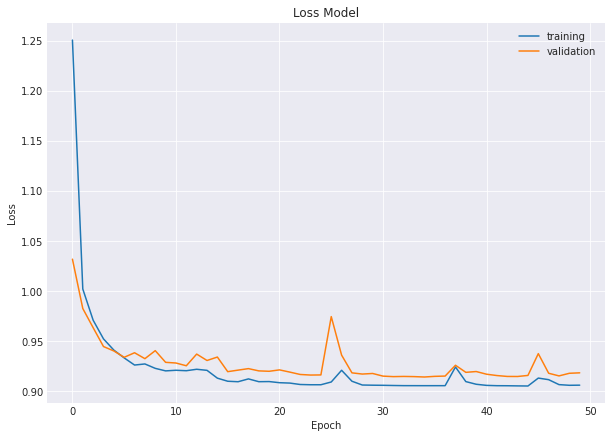

In [14]:
train_loss = optim_model.history[:, 'train_loss']
valid_loss = optim_model.history[:, 'valid_loss']

plt.figure(figsize=(10,7))
plt.plot(train_loss, label='training')
plt.plot(valid_loss, label='validation')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('plot/loss-plot-temp.png')
plt.show()

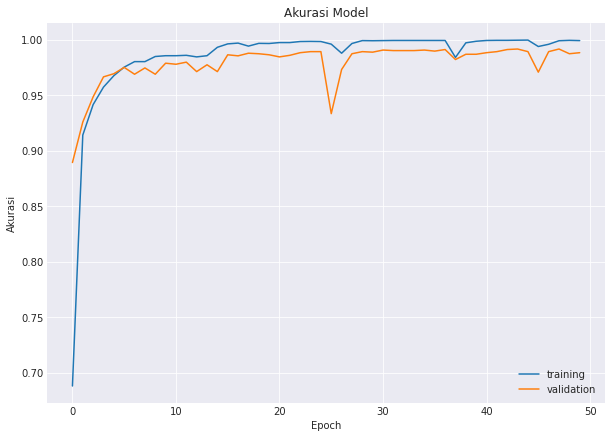

In [15]:
train_acc = optim_model.history[:, 'accuracy']
valid_acc = optim_model.history[:, 'valid_acc']

plt.figure(figsize=(10, 7))
plt.plot(train_acc, label='training')
plt.plot(valid_acc, label='validation')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='lower right')
plt.savefig('plot/acc-plot-temp.png')
plt.show()

In [16]:
y_pred = optim_model.predict(x_test)

In [17]:
test_acc = accuracy_score(y_test, y_pred)

print(f'Akurasi model pada data uji adalah {test_acc} persen')

Akurasi model pada data uji adalah 0.9931914893617021 persen


In [18]:
target_names = ['Safe driving','Texting-right','Talking on the phone-right','Texting-left','Talking on the phone-left']

print(classification_report(y_test, y_pred, target_names=target_names))

                            precision    recall  f1-score   support

              Safe driving       0.99      0.99      0.99       249
             Texting-right       1.00      0.99      0.99       227
Talking on the phone-right       1.00      1.00      1.00       232
              Texting-left       1.00      0.99      0.99       235
 Talking on the phone-left       0.99      1.00      0.99       232

                  accuracy                           0.99      1175
                 macro avg       0.99      0.99      0.99      1175
              weighted avg       0.99      0.99      0.99      1175



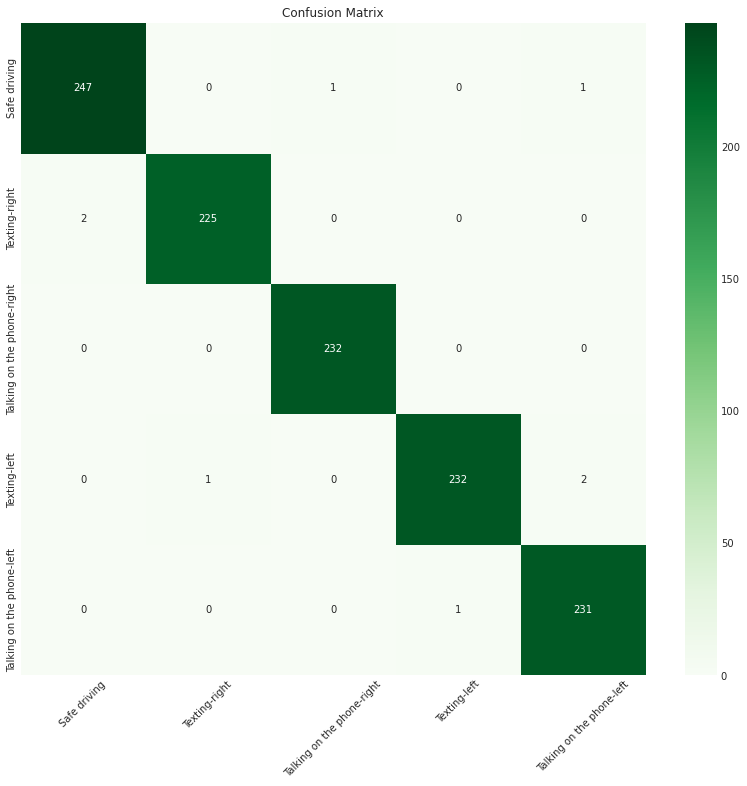

In [19]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, 
                     index=target_names,
                     columns=target_names)

plt.figure(figsize=(14,12))
sns.heatmap(df_cm, annot=True, cmap='Greens', fmt='g')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.savefig('plot/cf-plot-temp.png')
plt.show()

In [20]:
mispred_df = test_df
mispred_df['y_test'] = y_test
mispred_df['y_pred'] = y_pred

mispred_df = mispred_df[mispred_df['y_test'] != mispred_df['y_pred']]

print(f"Jumlah data yang misklasifikasi sebanyak {len(mispred_df)} dari {len(test_df)}")

Jumlah data yang misklasifikasi sebanyak 8 dari 1175


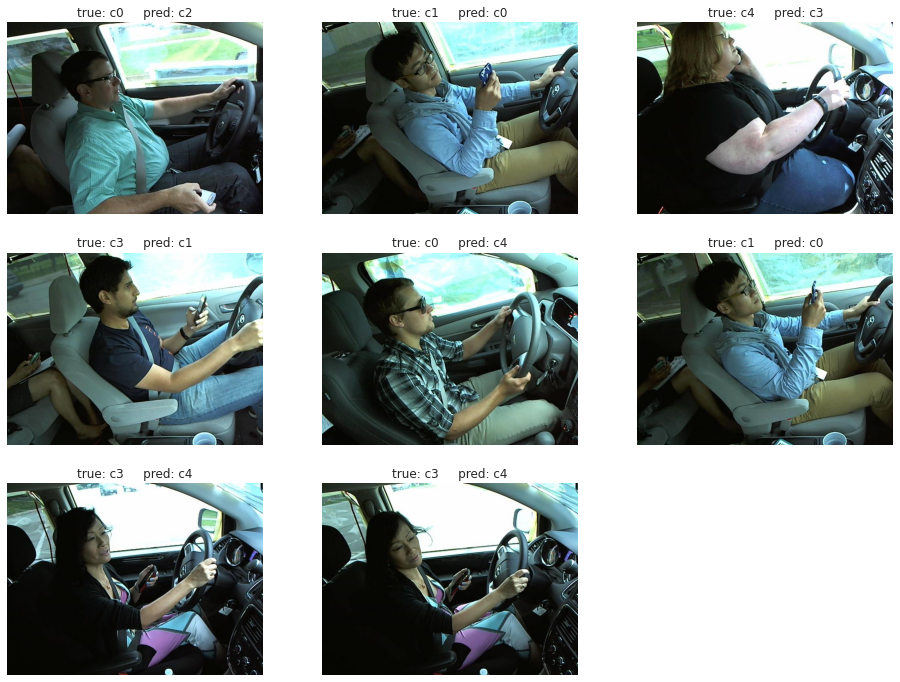

In [24]:
plt.figure(figsize=(16, 12))
for i, rows in mispred_df.sample(8).reset_index(drop=True).iterrows():
    plt.subplot(330 + 1 + i)
    img = plt.imread(f"{imgs_path + rows['classname']}/{rows['img']}")
    plt.title(f"true: c{rows['y_test']}     pred: c{rows['y_pred']}")
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

plt.savefig('plot/mispred-plot-temp.png')
plt.show()

In [ ]:
# from torch.nn.init import kaiming_uniform, xavier_uniform

In [ ]:
# class ConvNeuralNet(Module):
#     def __init__(self, hidden=10):
#         super().__init__()
#         self.layers = Sequential(
#             Conv2d(3, 4, kernel_size=(3, 3), stride=1, padding=0, dilation=1, bias=False),
#             ReLU(),
#             Conv2d(4, 3, kernel_size=(3, 3), stride=1, padding=0, dilation=1, bias=False),
#             ReLU(),
#             MaxPool2d(2, 2),
#             Flatten(),
#             Linear(3 * 30 * 30, hidden,  bias=False),
#             ReLU(),
#             Linear(hidden, 5, bias=False),
#             Softmax(dim=1)
#         )

#     def forward(self, x):
#         return self.layers(x)

In [ ]:
# class ConvNeuralNet(Module):
#     def __init__(self, hidden, act='relu', initializer=None):
#         super().__init__()
#         self.conv1 = Conv2d(in_channels=3,
#                             out_channels=4,
#                             kernel_size=(3, 3),
#                             bias=False)
        
#         self.conv2 = Conv2d(in_channels=4,
#                         out_channels=3,
#                         kernel_size=(3, 3),
#                         bias=False)
        
#         self.pool = MaxPool2d(2, 2)
        
#         self.fc1 = Linear(in_features=3 * 30 * 30,
#                           out_features=hidden,
#                           bias=False)
        
#         self.fc2 = Linear(in_features=hidden,
#                           out_features=5,
#                           bias=False)
        
#         self.softmax = Softmax(dim=1)
        
        
#         if initializer:
#             if initializer == 'kaiming_uniform':
#                 kaiming_uniform(self.conv1.weight)
#                 kaiming_uniform(self.conv2.weight)
#                 kaiming_uniform(self.fc1.weight)
#                 kaiming_uniform(self.fc2.weight)
#             elif initializer == 'xavier_uniform':
#                 xavier_uniform(self.conv1.weight)
#                 xavier_uniform(self.conv2.weight)
#                 xavier_uniform(self.fc1.weight)
#                 xavier_uniform(self.fc2.weight) 

        
#         if act=='sigmoid':
#             self.act = Sigmoid()
#         elif act=='tanh':
#             self.act = Tanh()
#         else:
#             self.act = ReLU()
    

#     def forward(self, x_input):
#         x = self.act(self.conv1(x_input))
#         x = self.act(self.conv2(x))
#         x = self.pool(x)
#         x = self.act(self.fc1(torch.flatten(x, start_dim=1)))
#         x = self.softmax(self.fc2(x))

#         return x

In [ ]:
# param_grid = {'lr': [0.0001, 0.001, 0.01, 0.1, 0.5],
#               'module__hidden': [4, 8, 16, 32, 64],
#               'module__act': ['relu', 'sigmoid', 'tanh'],
#               'module__initializer': [None, 'kaiming_uniform', 'xavier_uniform'],
#               'batch_size': [8, 16, 32, 64, 128],
#               'max_epochs': [10, 15, 20, 25, 50],
#               'optimizer': [Adam, SGD]}

### 
---

In [ ]:
# import os
# import numpy as np
# import pandas as pd
# from skimage import io

# import torchvision
# from torchvision import transforms, utils
# from torch.utils.data import Dataset, DataLoader
# from torch.utils.data.dataloader import default_collate


# from skorch.dataset import CVSplit
# from skorch.helper import SliceDataset
# from skorch.callbacks import EpochScoring
# from skorch.classifier import NeuralNetClassifier

# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import make_scorer, accuracy_score

# import torch
# from torch.optim import Adam
# from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Flatten, Softmax

# import warnings
# warnings.filterwarnings("ignore")

In [ ]:
# df = pd.read_csv(csv_file, usecols=['classname', 'img'])
# df = df[df['classname'].isin(['c0', 'c1', 'c2', 'c3', 'c4'])].reset_index(drop=True)

In [ ]:
# class DistractedDriverDataset(Dataset):
#     def __init__(self, data_frame, root:str, transform=None):
#         self.df = data_frame
#         self.root = root
#         self.transform = transform
#         # self.targets = torch.from_numpy(np.asarray(self.df['classname'].str.extract('(\d+)', expand=False), dtype=int))
    
#     def __len__(self):
#         return len(self.df)
    
#     def __getitem__(self, index):
#         img_path = os.path.join(self.root, self.df.iloc[index, 0], self.df.iloc[index, 1])
#         image = io.imread(img_path)
#         label = torch.tensor(int(self.df.iloc[index, 0][1]))
        
#         if self.transform:
#             image = self.transform(image)
        
#         return image, label

In [ ]:
# train_set, test_set = train_test_split(df, test_size=test_ratio)

In [ ]:
# transform = transforms.Compose([transforms.ToPILImage(),
#                                 transforms.Resize(img_size),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(torch.Tensor([0.3106, 0.3777, 0.3695]), 
#                                                      torch.Tensor([0.2701, 0.3156, 0.3163]))])

In [ ]:
# train_dataset = DistractedDriverDataset(train_set, imgs_path, transform)
# test_dataset = DistractedDriverDataset(test_set, imgs_path, transform)

In [ ]:
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

---

In [ ]:
# def data_prep(base_path, csv_filename, size: list, test_ratio=0.2):
#     # size[0] as height, size[1] as width
#     df = pd.read_csv(csv_filename, usecols=['classname', 'img'])
#     df = df[df['classname'].isin(['c0', 'c1', 'c2', 'c3', 'c4'])].reset_index(drop=True)
#     # df.to_csv(csv_filename.split('.')[0]+'_using_phone.csv', sep=',', encoding='utf-8', index=False)
    
#     images = []
#     print("Images resized to ", size)
#     for path in df.values:
#         image = cv2.imread(f"{base_path + path[0]}/{path[1]}").astype('float32')
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = cv2.resize(image, tuple(size))
#         images.append(image)

#     X = np.array(images) / 255.0  # Normalisasi data
#     y = np.asarray(df['classname'].str.extract('(\d+)', expand=False), dtype=np.int64)

#     # x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=123)
    
#     x_train = x_train.reshape(x_train.shape[0], 3, size[0], size[1]).astype(np.float32)
#     # print(x_train.shape, y_train.shape)

#     x_test = x_test.reshape(x_test.shape[0], 3, size[0], size[1]).astype(np.float32)
#     # print(x_test.shape, y_test.shape)

#     return x_train, y_train, x_test, y_test

In [ ]:
# x_train, y_train, x_test, y_test = data_prep(imgs_path, csv_file, img_size, test_ratio)

In [ ]:
# class ConvNeuralNet(Module):
#     def __init__(self, hidden):
#         super().__init__()
#         self.layers = Sequential(
#             Conv2d(3, 16, kernel_size=(3, 3), bias=True),
#             ReLU(),
#             Conv2d(16, 32, kernel_size=(3, 3), bias=True),
#             ReLU(),
#             MaxPool2d(2, 2),
#             Flatten(),
#             Linear(32 * 13 * 18, hidden, bias=True),
#             ReLU(),
#             Linear(hidden, 5, bias=True),
#             Softmax(dim=1)
#         )

#     def forward(self, x):
#         return self.layers(x)

In [ ]:
# param_grid = {'lr': [0.0001, 0.001, 0.01, 0.1, 0.5],
#               'module__hidden': [8, 10, 12, 16, 32],
#               'batch_size': [8, 16, 32, 64, 128],
#               'max_epochs': [5, 10, 15, 20, 25],
#               'optimizer': [Adam, SGD]}

In [ ]:
# params = GridSearchCV(model,
#                       param_grid,
#                       cv=k,
#                       scoring='accuracy',
#                       return_train_score=True,
#                       verbose=1
#                      ).fit(x_train, y_train)

---
---

In [ ]:
def data_prep(base_path, csv_filename, size: list, test_ratio=0.2):
  # size[0] as height, size[1] as width
  df = pd.read_csv(csv_filename, usecols=['classname', 'img'])
  df = df[df['classname'].isin(['c0', 'c1', 'c2', 'c3', 'c4'])].reset_index(drop=True)
  # df.to_csv(csv_filename.split('.')[0]+'_using_phone.csv', sep=',', encoding='utf-8', index=False)
  images = []
  print("Image resized to ", size)
  for path in df.values:
    image = cv2.imread(f"{base_path + path[0]}/{path[1]}").astype('uint8')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, tuple(size))
    images.append(image)

  X = np.array(images) / 255.0  # Normalisasi data
  y = np.asarray(df['classname'].str.extract('(\d+)', expand=False), dtype=int)

  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
  print("{:<18}: {} sample".format("Total samples", X.shape[0]))
  print("{:<18}: {} sample".format("Train samples", x_train.shape[0]))
  print("{:<18}: {} sample".format("Test samples", x_test.shape[0]))

  x_train = x_train.reshape(x_train.shape[0], 3, size[0], size[1]).astype(np.float32)
  x_train = torch.from_numpy(x_train)
    
  y_train = y_train.astype(np.int64)
  y_train = torch.from_numpy(y_train)
    
  # print(x_train.shape, y_train.shape)

  x_test = x_test.reshape(x_test.shape[0], 3, size[0], size[1]).astype(np.float32)
  x_test = torch.from_numpy(x_test)

  y_test = y_test.astype(np.int64)
  y_test = torch.from_numpy(y_test)

  # print(x_test.shape, y_test.shape)

  train_set = TensorDataset(x_train, y_train)
  test_set = TensorDataset(x_test, y_test)
    
  # return x_train, y_train, x_test, y_test
  return train_set, test_set

In [ ]:
def reset_weights(model):
  for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
      # print(f'Reset trainable parameters of layer = {layer}')
      layer.reset_parameters()

In [ ]:
def train(fold, model, device, train_loader, optimizer, loss_fn, epoch, n_epochs):
  model.train()
  epoch_start_time = time.time()
  acc, losses = 0.0, 0.0
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device).float(), target.to(device)
    optimizer.zero_grad()
    output = model(data).to(device)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    acc += np.sum(np.argmax(output.cpu().data.numpy(), axis=1) == target.cpu().data.numpy())
    losses += loss.item()

  print("Fold {} -- [{:03d}/{:03d}] {:.2f} detik | TRAIN acc: {:.10f} loss: {:.10f}".format(
    fold,
    epoch + 1, n_epochs,
    time.time() - epoch_start_time,
    acc / len(train_loader.dataset),
    loss / len(train_loader.dataset)))


def validation(fold, model, device, val_loader, loss_fn):
  model.eval()
  acc, loss = 0.0, 0.0
  with torch.no_grad():
    for data, target in val_loader:
      data, target = data.to(device).float(), target.to(device)
      output = model(data).to(device)

      total += target.size(0)
      acc += np.sum(np.argmax(output.cpu().data.numpy(), axis=1) == target.cpu().data.numpy())
      loss += loss_fn(output, target)

    print("\nHasil u/ Fold ke-{} = acc: {:.10f} loss: {:.10f}".format(fold,
                                                                      acc / total,
                                                                      loss / total))
  print('-'*32)

  return (acc/total * 100.0), loss/total


def test(model, device, test_loader, loss_fn):
  acc, losses = 0.0, 0.0
  pred_times = []

  with torch.no_grad():
    for data, target in test_loader:
      pred_start_time = time.time()
      data, target = data.to(device).float(), target.to(device)

      output = model(data)
      loss = loss_fn(output, target)

      acc += np.sum(np.argmax(output.cpu().data.numpy(), axis=1) == target.cpu().data.numpy())
      losses += loss.item()

      pred_time = time.time() - pred_start_time
      pred_times.append(pred_time)

  print("{:<25} : {:.3f} detik".format("Rata-rata waktu komputasi", np.sum(pred_times) / len(pred_times)))
  print("{:<25} : {:.3f} detik".format("Waktu komputasi tertinggi", np.max(pred_times)))
  print("{:<25} : {:.3f} detik".format("Waktu komputasi terendah", np.min(pred_times)))
  print('-' * 40)
  print("{:<25} : {:.3f}".format("Akurasi Testing", acc / len(test_loader.dataset)))
  print("{:<25} : {:.3f}".format("Loss Testing", loss / len(test_loader.dataset)))

In [ ]:
imgs_path = f'imgs/'
csv_file = 'driver_imgs_list.csv'
img_size = [60, 80]
test_ratio = 0.2

k = 8
n_epochs = 10
batch_size = 32

In [ ]:
x, y = data_prep(imgs_path, csv_file, img_size, test_ratio)

In [ ]:
param_grid = {'lr': [0.0001, 0.001, 0.01, 0.1, 0.5],
              'module__hidden': [8, 10, 12, 14, 16],
              'iterator_train__batch_size': [8, 16, 32, 64, 128],
              'iterator_valid__batch_size': [8, 16, 32, 64, 128],
              'max_epochs': [5, 10, 15, 20, 25]}

In [ ]:
cnn = NeuralNetClassifier(
    CNN,
    optimizer=torch.optim.Adam,
    criterion=CrossEntropyLoss,
    device=device,
)

In [ ]:
print(', '.join(cnn.prefixes_))

In [ ]:
gs = GridSearchCV(cnn, param_grid, cv=8, scoring='accuracy')

In [ ]:
gs.fit(x, y)

In [ ]:
train_set, test_set = data_prep(imgs_path, csv_file, img_size, test_ratio)

In [ ]:
model = CNN().to(device)
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = CrossEntropyLoss().to(device)
# print(model)

In [ ]:
kfold = StratifiedKFold(n_splits=k, shuffle=True)
hasil = {}

In [ ]:
# Training loop
print('-'*32)
for fold, (train_ids, test_ids) in enumerate(kfold.split(train_set)):
  print(f'FOLD {fold}')
  print('-'*32)

  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

  train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_subsampler)
  val_loader = DataLoader(train_set, batch_size=batch_size, sampler=test_subsampler)

  model.apply(reset_weights)

  for epoch in range(n_epochs):
    train(fold, model, device, train_loader, optimizer, loss_fn, epoch, n_epochs)

  acc, loss = validation(fold, model, device, val_loader, loss_fn)
  hasil[fold] = [acc, loss]

print(f'HASIL {k}-FOLD CROSS VALIDATION')
print('-'*32)
sum = 0.0
for key, values in hasil.items():
  print(f'Fold {key}: {values[0]} %')
  sum += values[0]
print(f'Rata-rata: {sum / len(hasil.items())} %')
print('\nTraining Selesai')

In [ ]:
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
test(model, device, test_loader, loss_fn)